# 🦠 VirusVision 
**What this notebook contains**
- Data loading (tf.data) + EDA (sample images, class counts)
- Data augmentation pipeline
- Model architecture (a clean CNN using Keras Functional API)
- Training loop with callbacks: ModelCheckpoint, EarlyStopping, TensorBoard
- Plots: training/validation accuracy & loss
- Evaluation: precision, recall, F1, confusion matrix, ROC/AUC
- Grad-CAM explainability
- Save artifacts: `labels.txt`, `best_model.keras`
- Convert to TFLite (with optional representative dataset for quantization)
- Single-image & batch inference demo

In [1]:
# Core imports & config
import os
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Display device (optional)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# --- USER CONFIG ---
DATA_DIR = "C:\\VIRUS-VISION-MLOP\\data\\LC25000\\"  
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20
MODEL_OUTPUT = "best_model.keras"
TFLITE_OUTPUT = "best_model.tflite"
LOG_DIR = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


TensorFlow version: 2.20.0
GPU available: []


In [3]:
# Create train/val/test splits using image_dataset_from_directory
# Directory structure: DATA_DIR/
#    class_A/
#    class_B/
#    ...
seed = 123

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'  # integer labels
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Optional: create a small test dataset from validation or separate folder
test_ds = val_ds.take(10)  # placeholder; replace with a real test split if available

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


Found 12750 files belonging to 2 classes.
Using 10200 files for training.
Found 12750 files belonging to 2 classes.
Using 2550 files for validation.
Classes: ['test', 'train']


In [4]:
# Performance: caching & prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation as a Keras Sequential model (applies in model)
data_augmentation = keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),            # safety
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
], name="data_augmentation")

# Normalization layer
normalization_layer = layers.Rescaling(1./255)


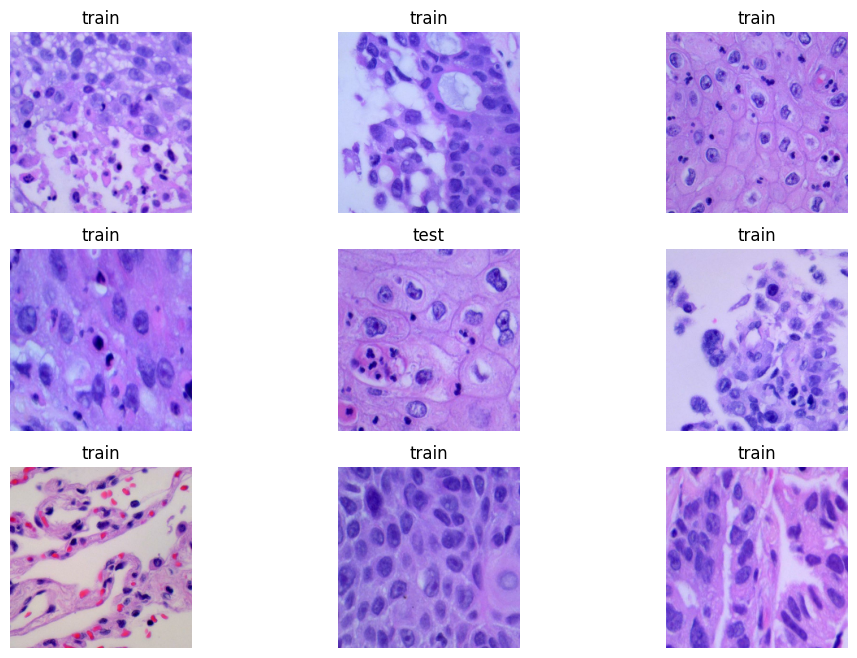

Found 12750 files belonging to 2 classes.
Approx class counts: {'test': 1500, 'train': 11250}


In [5]:
# EDA: show sample images and class distribution


# show a few sample images from the training dataset
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# class distribution (approx from directory counts)
from collections import Counter
label_counts = Counter()
for _, labels in tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR, batch_size=1, image_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False):
    for lab in labels.numpy():
        label_counts[class_names[lab]] += 1
print("Approx class counts:", dict(label_counts))


In [6]:
# Build a compact CNN model using the Functional API
def build_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES, dropout_rate=0.35):
    inputs = keras.Input(shape=input_shape, name="input_image")
    x = data_augmentation(inputs)            # augmentation only in training
    x = normalization_layer(x)

    # Feature extractor
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="VirusVision_CNN")
    return model

model = build_model()
model.summary()


Model: "VirusVision_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,426 (435.26 KB)

 Trainable params: 110,722 (432.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [7]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # because labels are ints
    metrics=['accuracy']
)

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_OUTPUT, save_best_only=True, monitor='val_accuracy', mode='max'
)
earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

callbacks = [checkpoint_cb, earlystop_cb, tensorboard_cb]


In [8]:
# Run `model.fit()` and stores the training `history`.

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.5314 - loss: 0.8345 - val_accuracy: 0.7051 - val_loss: 0.5736
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - accuracy: 0.7474 - loss: 0.5493 - val_accuracy: 0.8600 - val_loss: 0.5330
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.8605 - loss: 0.4465 - val_accuracy: 0.8902 - val_loss: 0.4187
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.8708 - loss: 0.4114 - val_accuracy: 0.8902 - val_loss: 0.3579
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.8826 - loss: 0.3797 - val_accuracy: 0.8902 - val_loss: 0.3650
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.8844 - loss: 0.3706 - val_accuracy: 0.8902 - val_loss: 0.3629
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.8849 - loss: 0.3725 - val_accuracy: 0.8902 - val_loss: 0.3530
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.8795 - loss: 0.3791 - val_accu

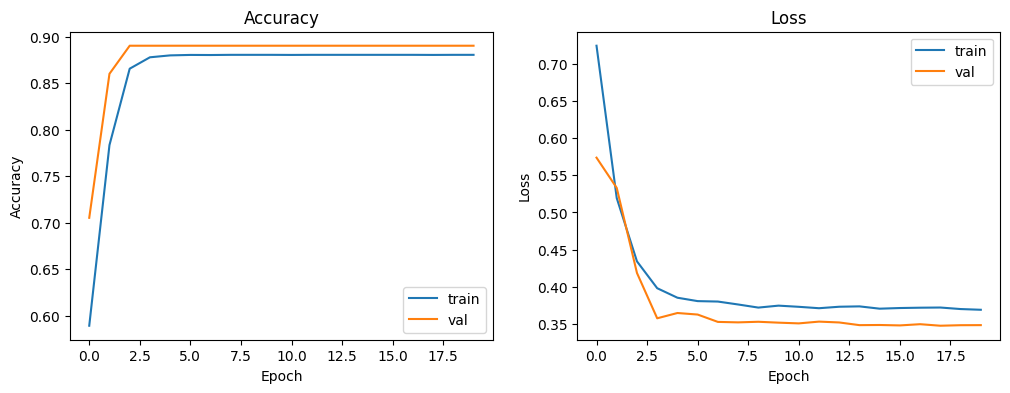

In [9]:
# Plot training & validation curves
hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.get('accuracy', hist.get('acc')), label='train')
plt.plot(hist.get('val_accuracy', hist.get('val_acc')), label='val')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()


In [10]:
# Gather predictions across the whole validation set
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    probs = model.predict(images)           # (batch, n_classes)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
print("Collected", len(y_true), "validation examples")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Classification Report:
              precision    recall  f1-score   support

        test     0.0000    0.0000    0.0000       280
       train     0.8902    1.0000    0.9419      2270

    accuracy                         0.8902      2550
   macro avg     0.4451    0.5000    0.4710      2550
weighted avg     0.7924    0.8902    0.8385      2550



c:\virus-vision-MLOP\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\virus-vision-MLOP\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\virus-vision-MLOP\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


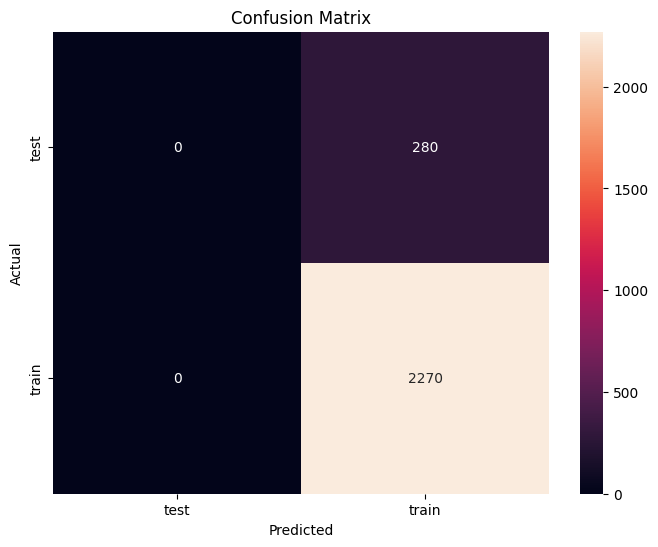

In [11]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


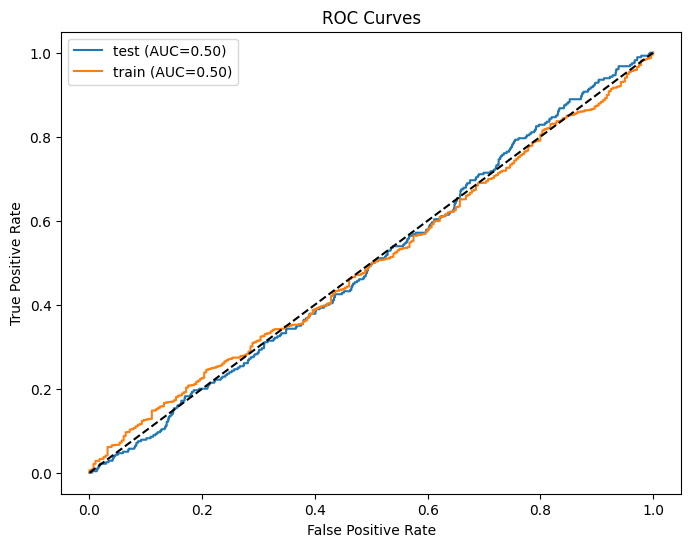

In [13]:

# ROC & AUC (multi-class)
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
# For binary problems sklearn may return a single column; convert to two-column format
if y_true_bin.ndim == 1 or (y_true_bin.ndim == 2 and y_true_bin.shape[1] == 1 and len(class_names) == 2):
    y_true_bin = np.hstack([1 - y_true_bin.reshape(-1, 1), y_true_bin.reshape(-1, 1)])
    plt.figure(figsize=(8,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{cname} (AUC={auc_score:.2f})')
    
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(); plt.show()


In [14]:
with open("labels.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")
print("Saved labels.txt with classes:", class_names)


Saved labels.txt with classes: ['test', 'train']


In [15]:
# The checkpoint callback should have saved the best model. If you want to (re)save:
model.save(MODEL_OUTPUT)
print("Model saved to", MODEL_OUTPUT)


Model saved to best_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


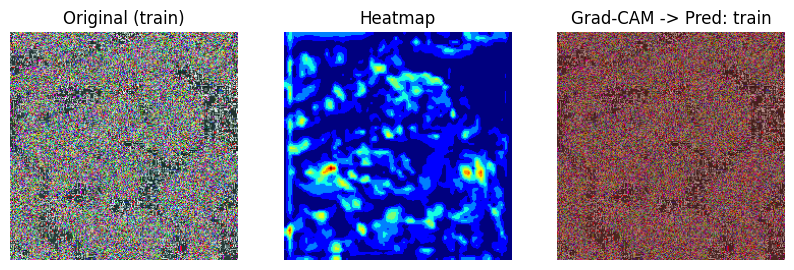

In [17]:
# Grad-CAM implementation (works for TF/Keras models)
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Demo: run Grad-CAM on a sample image (pick an image from validation or sample file)
for images, labels in val_ds.take(1):
    img = images[0:1]  # shape (1,H,W,3)
    true_label = labels[0].numpy()
    preds = model.predict(img)
    pred_idx = np.argmax(preds[0])

# Identify last conv layer automatically (best-effort)
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
assert last_conv_layer_name is not None, "No Conv2D layer found in model."

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name, pred_index=pred_idx)

# Superimpose heatmap on image
img_arr = (img[0].numpy() * 255).astype(np.uint8)
heatmap_resized = cv2.resize(heatmap, (img_arr.shape[1], img_arr.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_arr, 0.6, heatmap_color, 0.4, 0)

# Show
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_arr); plt.title(f"Original ({class_names[true_label]})"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(heatmap_resized, cmap='jet'); plt.title("Heatmap"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(superimposed_img); plt.title(f"Grad-CAM -> Pred: {class_names[pred_idx]}"); plt.axis('off')
plt.show()


In [18]:
import tensorflow as tf

# Load best model (if needed)
model = tf.keras.models.load_model(MODEL_OUTPUT)

# Basic conversion (float32)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(TFLITE_OUTPUT, "wb").write(tflite_model)
print("Saved basic TFLite model:", TFLITE_OUTPUT)

# Optional: full integer quantization (requires representative dataset function)
def representative_dataset_gen():
    # Yields batches of preprocessed images as float32
    for images, _ in train_ds.take(100):
        # images already from dataset pipeline; ensure dtype float32
        yield [tf.cast(images, tf.float32)]

# Uncomment the block below to run integer quantization (smaller & faster on some devices)
"""
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()
open("best_model_int8.tflite", "wb").write(tflite_quant_model)
print("Saved INT8 quantized TFLite model: best_model_int8.tflite")
"""


INFO:tensorflow:Assets written to: C:\Users\DOPIKE~1\AppData\Local\Temp\tmp3g7iw47w\assets


INFO:tensorflow:Assets written to: C:\Users\DOPIKE~1\AppData\Local\Temp\tmp3g7iw47w\assets


Saved artifact at 'C:\Users\DOPIKE~1\AppData\Local\Temp\tmp3g7iw47w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2166878516496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878515616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878533056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878534112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878531648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878532880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878549616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878548736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878566000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2166878567056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  216

'\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\nconverter.representative_dataset = representative_dataset_gen\nconverter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]\nconverter.inference_input_type = tf.uint8\nconverter.inference_output_type = tf.uint8\n\ntflite_quant_model = converter.convert()\nopen("best_model_int8.tflite", "wb").write(tflite_quant_model)\nprint("Saved INT8 quantized TFLite model: best_model_int8.tflite")\n'

In [19]:
import pandas as pd

predictions = []
image_paths = []

# If original dataset is accessible, iterate over files + preprocess them manually,
# or use val_ds to get images + labels
for images, labels in val_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)
    for i in range(images.shape[0]):
        predictions.append({
            "pred": class_names[preds[i]],
            "true": class_names[labels.numpy()[i]],
            "confidence": float(np.max(probs[i])),
        })

df = pd.DataFrame(predictions)
df.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,pred,true,confidence
0,train,train,0.905684
1,train,train,0.903672
2,train,train,0.876568
3,train,train,0.873616
4,train,train,0.876838


In [21]:
#  Single-image prediction demo

from PIL import Image

def preprocess_single_image(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = Image.open(path).convert('RGB').resize(target_size)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, 0).astype(np.float32)
    return arr

# Replace with your image path
single_img_path = "sample_test_image.jpg"  # <--- change this

if os.path.exists(single_img_path):
    x = preprocess_single_image(single_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    probs = model.predict(x)[0]
    pred_idx = int(np.argmax(probs))
    print("Predicted:", class_names[pred_idx], f"({probs[pred_idx]*100:.2f}%)")
else:
    print(f"Image not found at {single_img_path}. Please update the path and run again.")


Image not found at sample_test_image.jpg. Please update the path and run again.
